# Advanced ML example

Here, we reimplement sklearn [example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) that tests multiple classifiers on several datasets.

## The workflow

In [1]:
from functionfuse import workflow
from functionfuse.backends.builtin.localback import LocalWorkflow
from functionfuse.storage import storage_factory

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# List of classifiers to test

classifiers = [
    ("Nearest Neighbors", KNeighborsClassifier, {"n_neighbors": 3}),
    ("Linear SVM", SVC, {"kernel": "linear", "C": 0.025}),
    ("RBF SVM", SVC, {"gamma": 2, "C": 1}),
    ("Gaussian Process", GaussianProcessClassifier, {"kernel": 1.0 * RBF(1.0)}),
    ("Decision Tree", DecisionTreeClassifier, {"max_depth": 5}),
    ("Random Forest", RandomForestClassifier, {"max_depth": 5, "n_estimators": 10, "max_features": 1}),
    ("Neural Net", MLPClassifier, {"alpha": 1, "max_iter": 1000}),
    ("AdaBoost", AdaBoostClassifier, {}),
    ("Naive Bayes", GaussianNB, {}),
    ("QDA", QuadraticDiscriminantAnalysis, {})
]


# User function definitions to setup graph nodes

@workflow
def linearly_separable_dataset():
    import numpy as np
    from sklearn.datasets import make_classification

    X, y = make_classification(
        n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape) 

    return X, y
    

@workflow
def moons_dataset():
    from sklearn.datasets import make_moons
    return make_moons(noise=0.3, random_state=0)

@workflow
def circles_dataset():
    from sklearn.datasets import make_circles
    return make_circles(noise=0.2, factor=0.5, random_state=1)

@workflow
def train_test_split(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    return {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}


@workflow
def train_model(classifier_name, classifire_class, classifier_pars, X, y):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline
    clf = make_pipeline(StandardScaler(), classifire_class(**classifier_pars))
    clf.fit(X, y)
    print(f"Training model {classifier_name}")
    return clf


# Constructing nodes

datasets = [circles_dataset(), moons_dataset(), linearly_separable_dataset()]
datasets_names = ["circles_dataset", "moons_dataset", "linearly_separable_dataset"]

for ds_name, ds in zip(datasets_names, datasets):
    ds.set_name(f"{ds_name}_samples")
    dataset_split = train_test_split(X = ds[0], y = ds[1]).set_name(f"{ds_name}_split")
    for clf_name, clf_class, clf_pars in classifiers:
        model = train_model(
            clf_name, clf_class, clf_pars, 
            dataset_split["X_train"], dataset_split["y_train"]).set_name(f"{ds_name}, {clf_name}-model")



# Local backend with storage

local_workflow = LocalWorkflow(*datasets, workflow_name="classifiers")
opt = {
    "kind": "file",
    "options": {
        "path": "storage"
    }
}
storage = storage_factory(opt)
local_workflow.set_storage(storage)
_ = local_workflow.run()

Training model Nearest Neighbors
Training model Linear SVM
Training model RBF SVM
Training model Gaussian Process
Training model Decision Tree
Training model Random Forest
Training model Neural Net
Training model AdaBoost
Training model Naive Bayes
Training model QDA
Training model Nearest Neighbors
Training model Linear SVM
Training model RBF SVM
Training model Gaussian Process
Training model Decision Tree
Training model Random Forest
Training model Neural Net
Training model AdaBoost
Training model Naive Bayes
Training model QDA
Training model Nearest Neighbors
Training model Linear SVM
Training model RBF SVM
Training model Gaussian Process
Training model Decision Tree
Training model Random Forest
Training model Neural Net
Training model AdaBoost
Training model Naive Bayes
Training model QDA


## Model Prediction

The code above is designed to train models and save the workflow data in the storage. Typically this code should be placed in a separate Python module. I placed the workflow code in the Jupyter Notebook for demonstration purposes only. Final model analysis and data visualization are performed from the stored data in the Jupyter Notebook as shown below.

In [2]:
import os, pprint
from functionfuse.storage import storage_factory

the_workflow_name = "classifiers"
storage_path = "storage"
opt = {
    "kind": "file",
    "options": {
        "path": storage_path
    }
}
storage = storage_factory(opt)
all_tasks = storage.list_tasks(workflow_name=the_workflow_name, pattern="*")

pp = pprint.PrettyPrinter(width=141, compact=True)
print("All graph node names: ")
pp.pprint(all_tasks)

All graph node names: 
['circles_dataset, AdaBoost-model', 'circles_dataset, Decision Tree-model', 'circles_dataset, Gaussian Process-model',
 'circles_dataset, Linear SVM-model', 'circles_dataset, Naive Bayes-model', 'circles_dataset, Nearest Neighbors-model',
 'circles_dataset, Neural Net-model', 'circles_dataset, QDA-model', 'circles_dataset, RBF SVM-model', 'circles_dataset, Random Forest-model',
 'circles_dataset_samples', 'circles_dataset_split', 'linearly_separable_dataset, AdaBoost-model',
 'linearly_separable_dataset, Decision Tree-model', 'linearly_separable_dataset, Gaussian Process-model',
 'linearly_separable_dataset, Linear SVM-model', 'linearly_separable_dataset, Naive Bayes-model',
 'linearly_separable_dataset, Nearest Neighbors-model', 'linearly_separable_dataset, Neural Net-model',
 'linearly_separable_dataset, QDA-model', 'linearly_separable_dataset, RBF SVM-model', 'linearly_separable_dataset, Random Forest-model',
 'linearly_separable_dataset_samples', 'linearly_se

I parse names of datasets and trained models from the node names in our toy problem. In real-world workflows, we would use "hyperparameter nodes" and "metadata nodes" for that proposes.

In [3]:
models = storage.list_tasks(workflow_name="classifiers", pattern="*model")
models.sort()
print("Trained models:")
pp.pprint(models)
datasets = [i.split(",")[0] for i in models]
print("Datasets:")
pp.pprint(datasets)
model_names = [i.split(",")[1].strip() for i in models]
print("Model names:")
pp.pprint(model_names)

Trained models:
['circles_dataset, AdaBoost-model', 'circles_dataset, Decision Tree-model', 'circles_dataset, Gaussian Process-model',
 'circles_dataset, Linear SVM-model', 'circles_dataset, Naive Bayes-model', 'circles_dataset, Nearest Neighbors-model',
 'circles_dataset, Neural Net-model', 'circles_dataset, QDA-model', 'circles_dataset, RBF SVM-model', 'circles_dataset, Random Forest-model',
 'linearly_separable_dataset, AdaBoost-model', 'linearly_separable_dataset, Decision Tree-model',
 'linearly_separable_dataset, Gaussian Process-model', 'linearly_separable_dataset, Linear SVM-model',
 'linearly_separable_dataset, Naive Bayes-model', 'linearly_separable_dataset, Nearest Neighbors-model',
 'linearly_separable_dataset, Neural Net-model', 'linearly_separable_dataset, QDA-model', 'linearly_separable_dataset, RBF SVM-model',
 'linearly_separable_dataset, Random Forest-model', 'moons_dataset, AdaBoost-model', 'moons_dataset, Decision Tree-model',
 'moons_dataset, Gaussian Process-model

After parsing, we read node results and plot them.

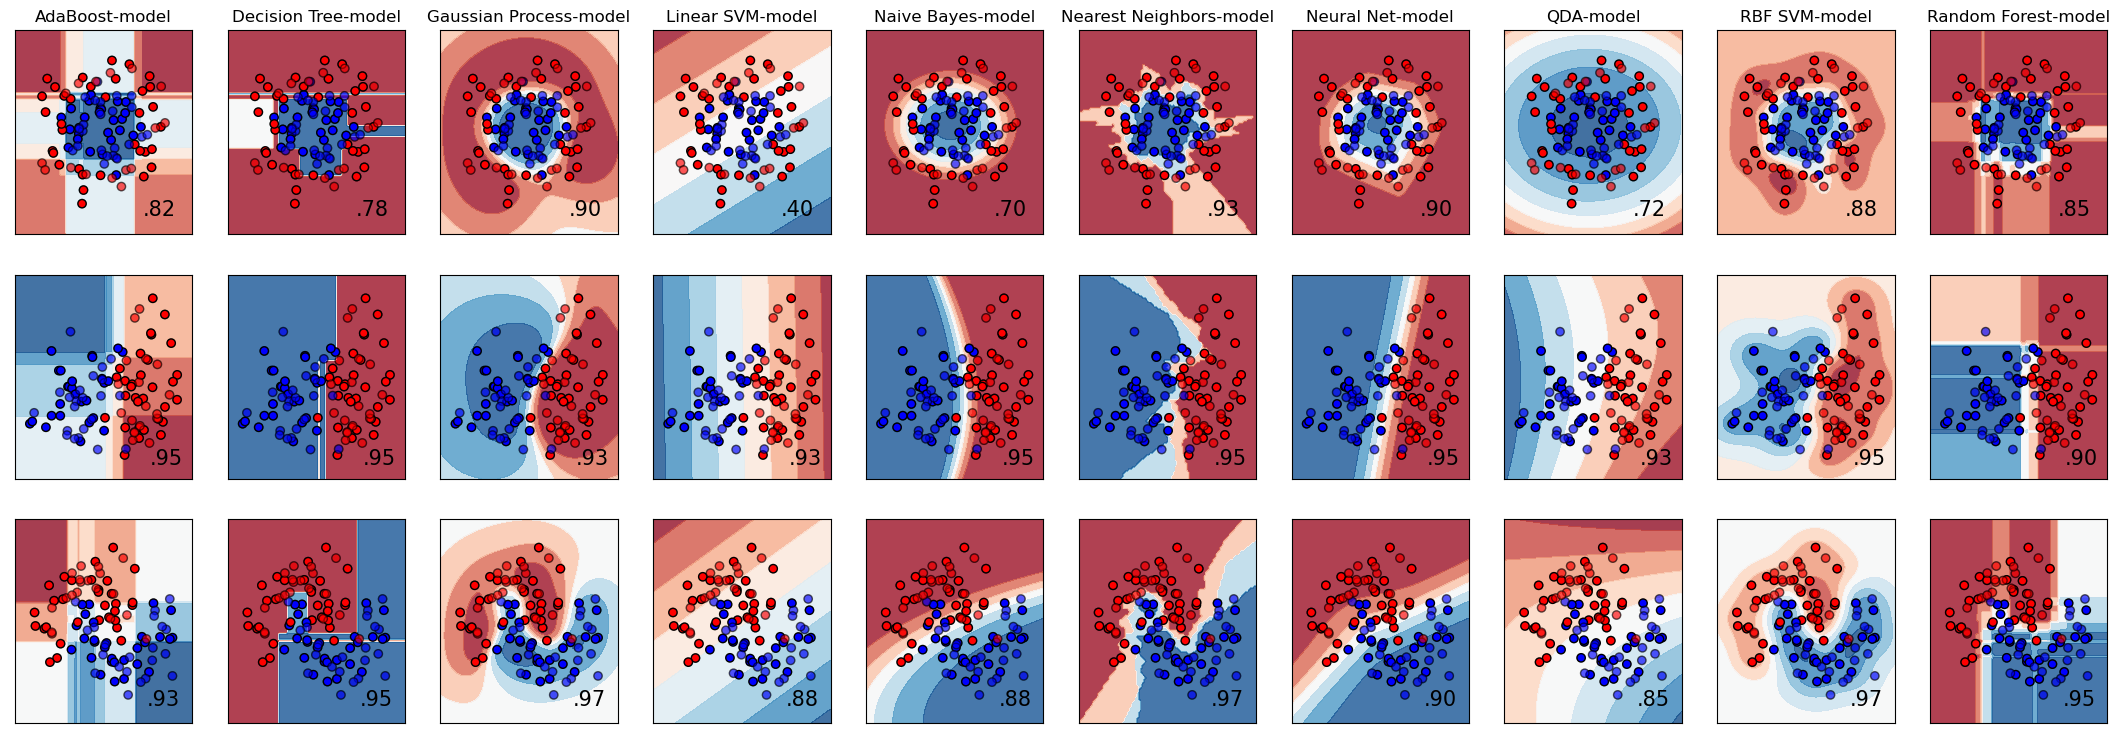

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
figure = plt.figure(figsize=(27, 9))
n_rows, n_cols = len(set(datasets)), len(set(model_names))

index = 0
for index, (model_name, model, dataset) in enumerate(zip(model_names, models, datasets)):
    
    X, _ = storage.read_task(workflow_name=the_workflow_name, task_name=f"{dataset}_samples")
    split = storage.read_task(workflow_name=the_workflow_name, task_name=f"{dataset}_split")
    X_train, y_train, X_test, y_test = split["X_train"], split["y_train"], split["X_test"], split["y_test"]
    trained_model = storage.read_task(workflow_name=the_workflow_name, task_name=model)
    score = trained_model.score(X_test, y_test)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5



    ax = plt.subplot(n_rows, n_cols, index + 1)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    DecisionBoundaryDisplay.from_estimator(trained_model, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5)

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    if index < n_cols:
        ax.set_title(model_name)
    ax.text(x_max - 0.3, y_min + 0.3, ("%.2f" % score).lstrip("0"), size=15, horizontalalignment="right")


